In [1]:
import pandas as pd
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# GPU Setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [9]:
covid_data = pd.read_csv('COVID_dataset.csv')

In [10]:
# Data_preprocss
# Fill the "Outbreak Related with No"
covid_data['Outbreak_Related'] = covid_data['Outbreak_Related'].fillna('No')

# Drop None
covid_data = covid_data.dropna()
# Drop time
covid_data = covid_data.drop(columns='Accurate_Episode_Date')
covid_data = covid_data.drop(columns='Case_Reported_Date')
covid_data = covid_data.drop(columns='Specimen_Date')
covid_data = covid_data.drop(columns='Test_Reported_Date')
# Convert Location
covid_data["Reporting_PHU_Latitude"] = covid_data["Reporting_PHU_Latitude"]/50
covid_data["Reporting_PHU_Longitude"] = covid_data["Reporting_PHU_Longitude"]/90

In [11]:
# Convert Dataframe
covid_data_age = pd.get_dummies(covid_data["Age_Group"], prefix="Age_Group")
covid_data_gender = pd.get_dummies(covid_data["Client_Gender"], prefix="Client_Gender")
covid_data_case = pd.get_dummies(covid_data["Case_AcquisitionInfo"], prefix="Case_AcquisitionInfo")
covid_data_city = pd.get_dummies(covid_data["Reporting_PHU_City"], prefix="PHU_City")

In [12]:
covid_data_final = pd.concat([covid_data, covid_data_age, covid_data_gender, covid_data_case, covid_data_city], axis=1)
covid_data_final = covid_data_final.drop(['Age_Group', 'Client_Gender', 'Case_AcquisitionInfo', 'Reporting_PHU_City'], axis=1)
covid_data_final['Outbreak_Related'] = covid_data_final['Outbreak_Related'].replace({'Yes':1, 'No':0})
covid_data_final['Outcome1'] = covid_data_final['Outcome1'].replace({'Resolved':0, 'Not Resolved':1, 'Fatal':2})

In [13]:
covid_data_final_train, covid_data_final_test = train_test_split(covid_data_final, test_size=0.2, random_state=42)
Y_test = covid_data_final_test['Outcome1']
X_test = covid_data_final_test.drop(columns='Outcome1')
Y_train = covid_data_final_train['Outcome1']
X_train = covid_data_final_train.drop(columns='Outcome1')
Y_test = Y_test.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
X_train = X_train.to_numpy()


In [14]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [22]:
model = Sequential()
model.add(LSTM(50,  activation='relu', input_shape = (1, 56)) )
model.add(Dense(1) )
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                21400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 21,451
Trainable params: 21,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train,Y_train,validation_split = 0.2, batch_size=128,epochs = 30)
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test, batch_size=128)
print('test loss, test acc:', results)

Epoch 1/30
74/74 [==============================] - 0s 4ms/step - loss: 0.2954 - accuracy: 0.4218 - val_loss: 0.3530 - val_accuracy: 0.3904
Epoch 2/30
74/74 [==============================] - 0s 4ms/step - loss: 0.2951 - accuracy: 0.4225 - val_loss: 0.3528 - val_accuracy: 0.3916

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


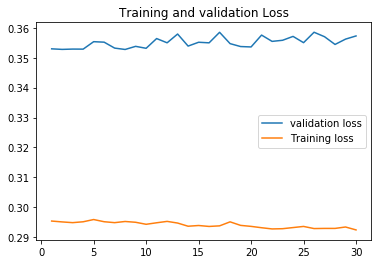

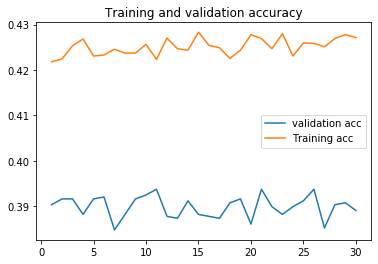

<Figure size 432x288 with 0 Axes>

In [28]:
print(history.history.keys())
acc = history.history['accuracy']
loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot
plt.plot(epochs, validation_loss, label='validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

plt.plot(epochs, validation_acc, label='validation acc')
plt.plot(epochs, acc, label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

